# Brain_Tumor with crop image

In [1]:
!pip install imutils

In [2]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils

In [4]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img
	
if __name__ == "__main__":
	training = "Training"
	testing = "Testing"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = 'cleaned/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'cleaned/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

In [5]:
# Necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

2023-01-09 23:56:07.656752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
data_dir = ('cleaned/Training')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))

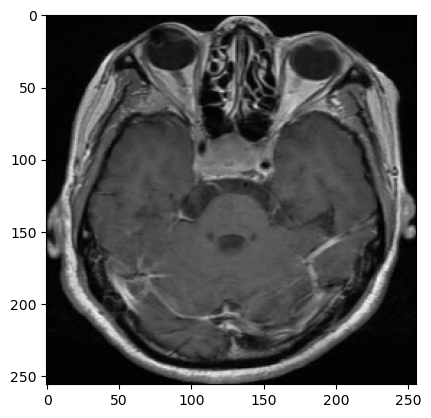

In [7]:
plt.imshow(img_array);

In [8]:
# The image shape.
img_array.shape

(256, 256, 3)

# Ploting a image of each brain tumor type

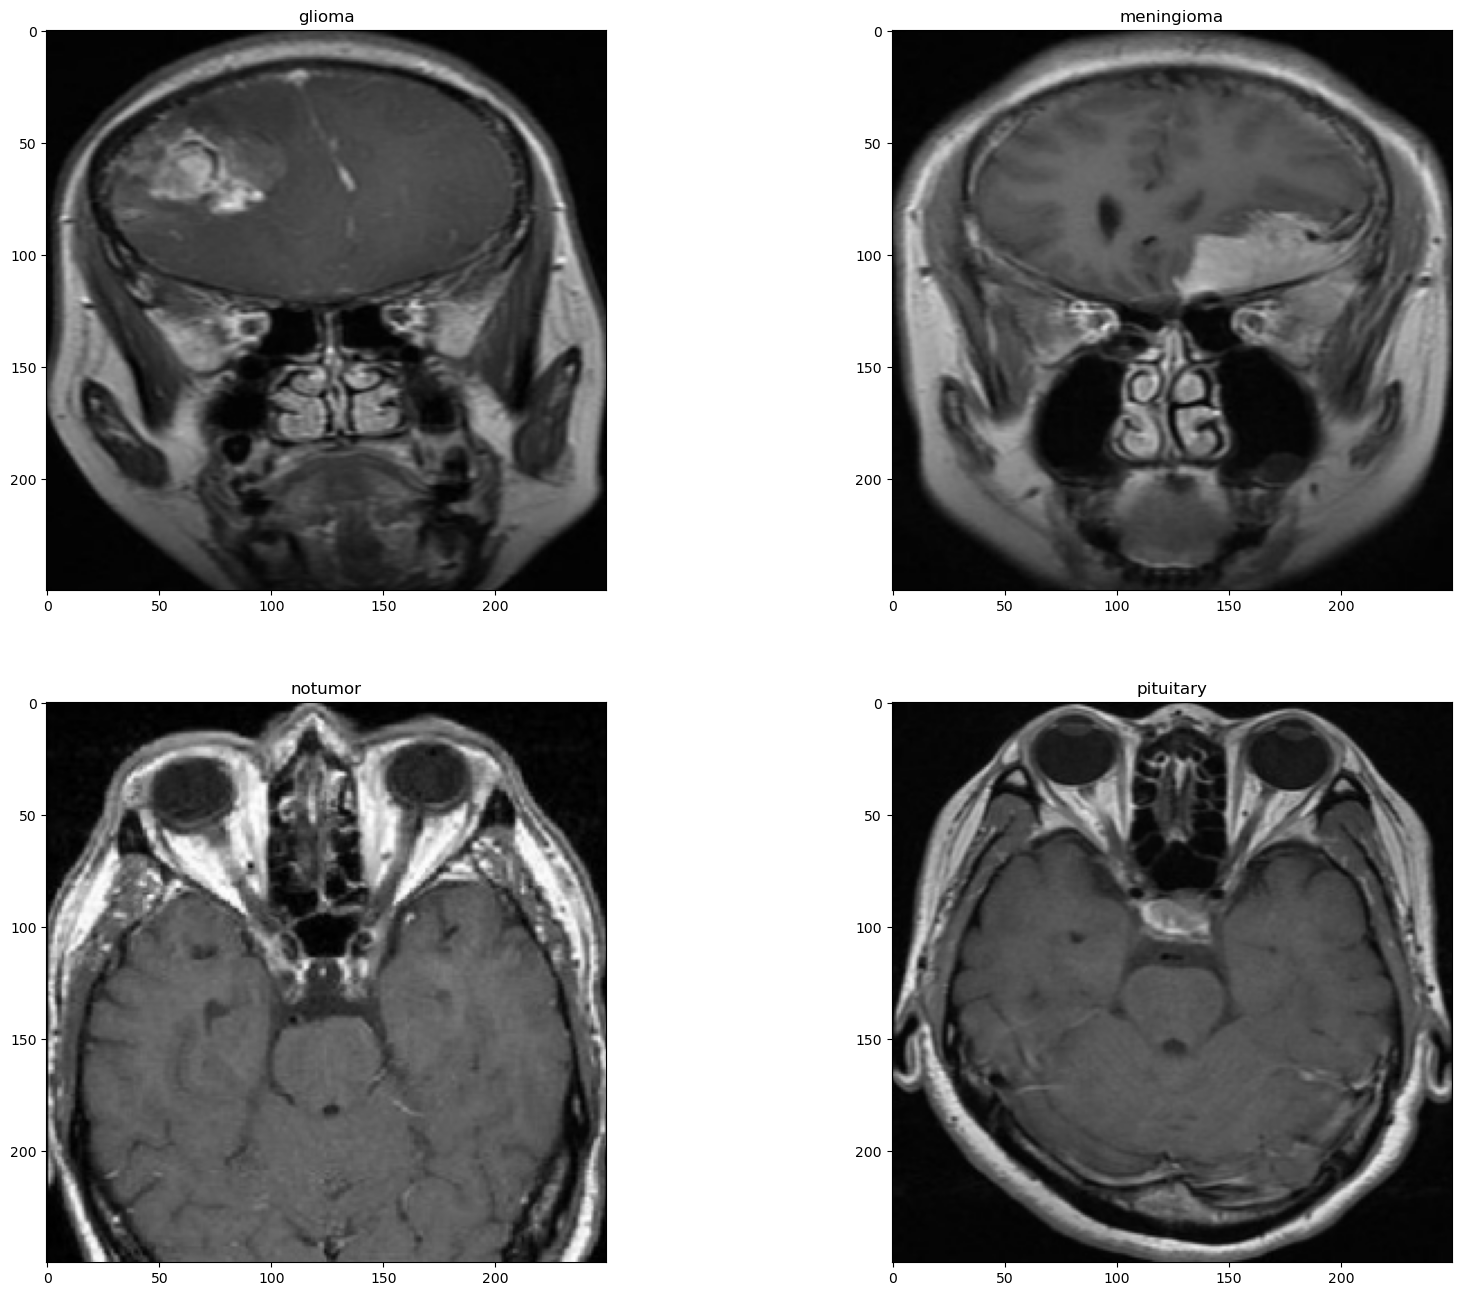

In [9]:
plt.figure(figsize=(20, 16))

images_path = ['/glioma/Tr-glTr_0000.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (250, 250))
    plt.imshow(img)
    plt.title(categories[i])

# Modelling: CNN

In [10]:
model1 = Sequential()
# Convolutional layer 1
model1.add(Conv2D(32,(3,3), input_shape=(64, 64, 1), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 2
model1.add(Conv2D(32,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Neural network

model1.add(Dense(units= 252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])



# using the ImageDataGenerator to prepare the images (Resize, nomalize, etc)

generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False) 


generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

2023-01-09 23:58:32.623119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 23:58:32.623679: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
# Creating the train and test data.

train = generator_train.flow_from_directory('cleaned/Training', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory('cleaned/Testing', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [12]:
# Creating callbacks for the model.
# If the model dosen't continue to improve (loss), the trainning will stop.

# Stop training if loss doesn't keep decreasing.
model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = 'model1_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

# Fiting the model.
history1 = model1.fit(train, steps_per_epoch=5712//32, epochs=100, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model1_es, model1_rlr, model1_mcp])

Epoch 1/100
178/178 [==============================] - ETA: 0s - loss: 0.8936 - categorical_accuracy: 0.7018
Epoch 1: val_categorical_accuracy improved from -inf to 0.51172, saving model to model1_weights.h5
178/178 [==============================] - 36s 199ms/step - loss: 0.8936 - categorical_accuracy: 0.7018 - val_loss: 4.4978 - val_categorical_accuracy: 0.5117 - lr: 0.0010
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 0.4307 - categorical_accuracy: 0.8433
Epoch 2: val_categorical_accuracy did not improve from 0.51172
178/178 [==============================] - 49s 277ms/step - loss: 0.4307 - categorical_accuracy: 0.8433 - val_loss: 6.3103 - val_categorical_accuracy: 0.3789 - lr: 0.0010
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 0.3027 - categorical_accuracy: 0.8875
Epoch 3: val_categorical_accuracy improved from 0.51172 to 0.56172, saving model to model1_weights.h5
178/178 [==============================] - 49s 276ms/step - loss: 0

In [13]:
model1.evaluate(test)

41/41 [==============================] - 3s 72ms/step - loss: 0.0811 - categorical_accuracy: 0.9825


[0.08108488470315933, 0.9824561476707458]

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 32)       128       
 hNormalization)                                                 
                                                        